# Building MNIST-1D
Sam Greydanus | 2020

This notebook shows how to build the MNIST-1D dataset in full detail*.

_* If you're running this in Colab, it's best to use a GPU runtime._

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
%cd '/content/drive/MyDrive'

/content/drive/MyDrive


In [ ]:
# Run this if you're in a Colab
#!git clone https://github.com/greydanus/mnist1d

In [ ]:
import numpy as np
import torch
import random
import matplotlib.pyplot as plt
from scipy.ndimage.filters import gaussian_filter
from scipy.interpolate import interp1d

PROJECT_DIR = './'

class ObjectView(object):
    def __init__(self, d): self.__dict__ = d
        
# Try attaching to GPU
DEVICE = str(torch.device('cuda' if torch.cuda.is_available() else 'cpu'))
print('Using:', DEVICE)

Using: cuda


## Templates
These are 1D signals, consisting of 12 points each, that resemble the digits 0-9. They are meant to be analogous to the handwritten digits 0-9 in the original MNIST dataset:

![mnist digits](https://raw.githubusercontent.com/greydanus/greydanus.github.io/master/files/mnist2d_black.png)

But unlike the original MNIST dataset, which consisted of 2D arrays of pixels (each image had 28x28=784 dimensions), this dataset consists of 1D timeseries of length 40. This means each example is ~20x smaller, making the dataset much quicker and easier to iterate over.

In [ ]:
def get_templates():
    d0 = np.asarray([5,6,6.5,6.75,7,7,7,7,6.75,6.5,6,5])
    d1 = np.asarray([5,3,3,3.4,3.8,4.2,4.6,5,5.4,5.8,5,5])
    d2 = np.asarray([5,6,6.5,6.5,6,5.25,4.75,4,3.5,3.5,4,5])
    d3 = np.asarray([5,6,6.5,6.5,6,5,5,6,6.5,6.5,6,5])
    d4 = np.asarray([5,4.4,3.8,3.2,2.6,2.6,5,5,5,5,5,5])
    d5 = np.asarray([5,3,3,3,3,5,6,6.5,6.5,6,4.5,5])
    d6 = np.asarray([5,4,3.5,3.25,3,3,3,3,3.25,3.5,4,5])
    d7 = np.asarray([5,7,7,6.6,6.2,5.8,5.4,5,4.6,4.2,5,5])
    d8 = np.asarray([5,4,3.5,3.5,4,5,5,4,3.5,3.5,4,5])
    d9 = np.asarray([5,4,3.5,3.5,4,5,5,5,5,4.7,4.3,5])
    
    x = np.stack([d0,d1,d2,d3,d4,d5,d6,d7,d8,d9])
    x -= x.mean(1,keepdims=True) # whiten
    x /= x.std(1,keepdims=True)
    x -= x[:,:1]  # signal starts and ends at 0
    
    templates = {'x': x/6., 't': np.linspace(-5, 5, len(d0))/6.,
                 'y': np.asarray([0,1,2,3,4,5,6,7,8,9])}
    return templates

def plot_signals(xs, t, labels=None, args=None, ratio=2.6, do_transform=False, dark_mode=False, zoom=1):
    rows, cols = 1, 10
    fig = plt.figure(figsize=[cols*1.5,rows*1.5*ratio], dpi=60)
    for r in range(rows):
        for c in range(cols):
            ix = r*cols + c
            x, t = xs[ix], t
            ax = plt.subplot(rows,cols,ix+1)

            # plot the data
            if do_transform:
                assert args is not None, "Need an args object in order to do transforms"
                x, t = transform(x, t, args)  # optionally, transform the signal in some manner
            if dark_mode:
                plt.plot(x, t, 'wo', linewidth=6)
                ax.set_facecolor('k')
            else:
                plt.plot(x, t, 'k-', linewidth=2)
            if labels is not None:
                plt.title("label=" + str(labels[ix]), fontsize=22)

            plt.xlim(-zoom,zoom) ; plt.ylim(-zoom,zoom)
            plt.gca().invert_yaxis() ; plt.xticks([], []), plt.yticks([], [])
    plt.subplots_adjust(wspace=0, hspace=0)
    plt.tight_layout() ; plt.show()
    return fig

In [ ]:
from IPython.display import Image
from IPython.core.display import HTML 
print("Examples from original MNIST dataset:")
URL = 'https://raw.githubusercontent.com/greydanus/mnist1d/master/static/mnist.png'
Image(url= URL,  width=800)

Examples from original MNIST dataset:


In [ ]:
templates = get_templates()
print("Templates for the MNIST-1D dataset:")
x = templates['x']
t = templates['t']
y = templates['y']
fig = plot_signals(x, t, labels=y, ratio=1.33, dark_mode=True)

# fig.savefig(PROJECT_DIR + 'static/mnist1d_black.png')

Templates for the MNIST-1D dataset:


Templates for the MNIST-1D dataset:


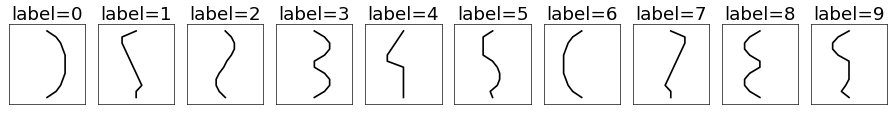

In [ ]:
templates = get_templates()
print("Templates for the MNIST-1D dataset:")
x = templates['x']
t = templates['t']
y = templates['y']
fig = plot_signals(x, t, labels=y, ratio=1.33, dark_mode=False)

# fig.savefig(PROJECT_DIR + 'static/mnist1d_white.png')

## Transformations
In order to build a synthetic dataset, we are going to pass the templates through a series of random transformations. This includes adding random amounts of padding, translation, correlated noise, iid noise, and scaling.

We use these transformations because they are relevant for both 1D and 2D images. So even though our dataset is 1D, we can expect some of our findings to hold for 2D (image) data. For example, we can study the advantage of using a translation-invariant model by making a dataset where signals occur at different locations in the sequence. We can do this by using large padding and translation coefficients.

In the following section, we plot the step-by-step transformations of digit templates into dataset examples. Note that you can generate your own synthetic datasets by changing the relevant hyperparameters.

In [ ]:
# transformations of the templates which will make them harder to fit
def pad(x, padding):
    low, high = padding
    p = low + int(np.random.rand()*(high-low+1))
    return np.concatenate([x, np.zeros((p))])

def shear(x, scale=10):
    coeff = scale*(np.random.rand() - 0.5)
    return x - coeff*np.linspace(-0.5,.5,len(x))

def translate(x, max_translation):
    k = np.random.choice(max_translation)
    return np.concatenate([x[-k:], x[:-k]])

def corr_noise_like(x, scale):
    noise = scale * np.random.randn(*x.shape)
    return gaussian_filter(noise, 2)

def iid_noise_like(x, scale):
    noise = scale * np.random.randn(*x.shape)
    return noise

def interpolate(x, N):
    scale = np.linspace(0,1,len(x))
    new_scale = np.linspace(0,1,N)
    new_x = interp1d(scale, x, axis=0, kind='linear')(new_scale)
    return new_x

def transform(x, y, args, eps=1e-8):
    new_x = pad(x+eps, args.padding) # pad
    new_x = interpolate(new_x, args.template_len + args.padding[-1])  # dilate
    new_y = interpolate(y, args.template_len + args.padding[-1])
    new_x *= (1 + args.scale_coeff*(np.random.rand() - 0.5))  # scale
    new_x = translate(new_x, args.max_translation)  #translate
    
    # add noise
    mask = new_x != 0
    new_x = mask*new_x + (1-mask)*corr_noise_like(new_x, args.corr_noise_scale)
    new_x = new_x + iid_noise_like(new_x, args.iid_noise_scale)
    
    # shear and interpolate
    new_x = shear(new_x, args.shear_scale)
    new_x = interpolate(new_x, args.final_seq_length) # subsample
    new_y = interpolate(new_y, args.final_seq_length)
    return new_x, new_y

def get_dataset_args(as_dict=False):
    arg_dict = {'num_samples': 1000,
            'train_split': 0.5,
            'template_len': 12,
            'padding': [36,60],
            'scale_coeff': .4, 
            'max_translation': 48,
            'corr_noise_scale': 0.25,
            'iid_noise_scale': 2e-2,
            'shear_scale': 0.75,
            'shuffle_seq': False,
            'final_seq_length': 40,
            'seed': 42}
    return arg_dict if as_dict else ObjectView(arg_dict)

## Visualize Transformations
We'll apply one at a time so it's clear what each transformation is doing.

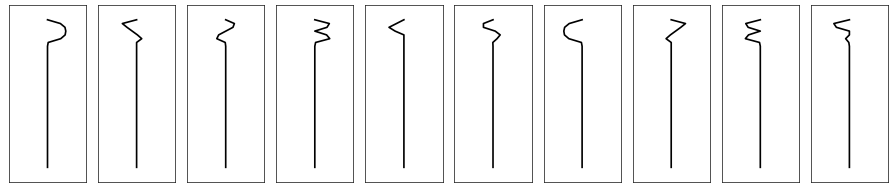

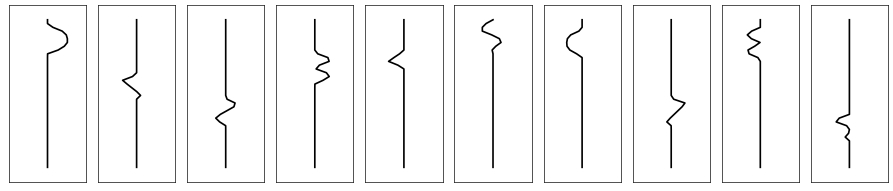

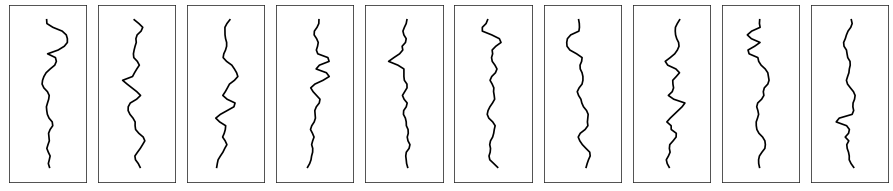

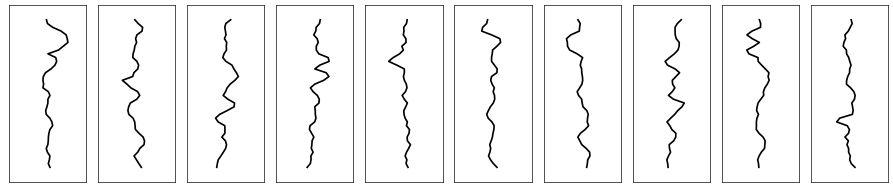

In [ ]:
def apply_ablations(arg_dict, n=7):
    ablations = [('shear_scale', 0),
                ('iid_noise_scale', 0),
                ('corr_noise_scale', 0),
                 ('max_translation', 1),
                 ('scale_coeff', 0),
                 ('padding', [arg_dict['padding'][-1], arg_dict['padding'][-1]]),
                 ('padding', [0, 0]),]
    num_ablations = min(n, len(ablations))
    for i in range(num_ablations):
        k, v = ablations[i]
        arg_dict[k] = v
    return arg_dict

templates = get_templates()
for i, n in enumerate(reversed(range(8))):
    np.random.seed(0)
    arg_dict = get_dataset_args(as_dict=True)
    arg_dict = apply_ablations(arg_dict, n=n)
    args = ObjectView(arg_dict)
    do_transform = args.padding[0] != 0
    fig = plot_signals(templates['x'], templates['t'], labels=None if do_transform else templates['y'],
                 args=args, ratio=2.2 if do_transform else 0.8,
                 do_transform=do_transform)
#     fig.savefig(PROJECT_DIR + 'static/transform_{}.png'.format(i))

## Construct a  dataset
Now we can construct a dataset by applying random transformations to the template signals.

In [ ]:
def make_dataset(args=None, template=None, ):
    templates = get_templates() if template is None else template
    args = get_dataset_args() if args is None else args
    np.random.seed(args.seed) # reproducibility
    
    xs, ys = [], []
    samples_per_class = args.num_samples // len(templates['y'])
    for label_ix in range(len(templates['y'])):
        for example_ix in range(samples_per_class):
            x = templates['x'][label_ix]
            t = templates['t']
            y = templates['y'][label_ix]
            x, new_t = transform(x, t, args) # new_t transformation is same each time
            xs.append(x) ; ys.append(y)
    
    batch_shuffle = np.random.permutation(len(ys)) # shuffle batch dimension
    xs = np.stack(xs)[batch_shuffle]
    ys = np.stack(ys)[batch_shuffle]
    
    if args.shuffle_seq: # maybe shuffle the spatial dimension
        seq_shuffle = np.random.permutation(args.final_seq_length)
        xs = xs[...,seq_shuffle]
    
    new_t = new_t/xs.std()
    xs = (xs-xs.mean())/xs.std() # center the dataset & set standard deviation to 1

    # train / test split
    split_ix = int(len(ys)*args.train_split)
    dataset = {'x': xs[:split_ix], 'x_test': xs[split_ix:],
               'y': ys[:split_ix], 'y_test': ys[split_ix:],
               't':new_t, 'templates': templates}
    return dataset

def set_seed(seed):
    random.seed(seed)
    np.random.seed(seed)
    torch.manual_seed(seed)
    torch.cuda.manual_seed_all(seed)

In [ ]:
args = get_dataset_args()
set_seed(args.seed)
args.shuffle_seq = False
data = make_dataset(args=args)  # make the dataset

set_seed(args.seed)
args.shuffle_seq = True
data_shuff = make_dataset(args=args)  # make the dataset, shuffling the spatial dimension

print("Examples in training set: {}".format(len(data['y'])))
print("Examples in test set: {}".format(len(data['y_test'])))
print("Length of each example: {}".format(data['x'].shape[-1]))
print("Number of classes: {}".format(len(data['templates']['y'])))

Examples in training set: 500
Examples in test set: 500
Length of each example: 40
Number of classes: 10


In [ ]:
np.save('train_X.npy',data['x'])
np.save('train_Y.npy',data['y'])

In [ ]:
from mnist1d.models import MLPBase, Single_Hidden_Layer
from mnist1d.train import get_model_args, train_model

In [ ]:
from scipy.ndimage.measurements import mean
import torch
import torch.nn as nn
import torch.nn.functional as F

In [ ]:
class Single_Hidden_Layer(nn.Module):

  def __init__(self, input_size, output_size, hidden_size=1000):
    super(Single_Hidden_Layer, self).__init__()
    self.linear1 = nn.Linear(input_size,hidden_size,bias=False)

    nn.init.normal_(self.linear1.weight,mean=0,std=1)

#    print(self.linear1.weight[:1])
    self.linear2 = nn.Linear(hidden_size, output_size)

    nn.init.uniform_(self.linear2.weight,-1,1)

#    print(self.linear2.weight)

    print("Initialized MLPBase model with {} parameters".format(self.count_params()))


  def count_params(self):
    return sum([p.view(-1).shape[0] for p in self.parameters()])

  def forward(self, x):
    h = self.linear1(x).relu()

    return self.linear2(h)

In [ ]:
print(data['x'].shape)

print(type(data['x']))

(500, 40)
<class 'numpy.ndarray'>


## Normalizing inputs (Theorem assumption)

In [ ]:
x_norm_row = np.linalg.norm(data['x'], axis=1)
print(x_norm_row.shape)

x_normalized = data['x']/x_norm_row.reshape(-1,1)

print(np.linalg.norm(x_normalized,axis=1))

(500,)
[1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1.
 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1.
 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1.
 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1.
 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1.
 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1.
 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1.
 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1.
 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1.
 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1.
 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1.
 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1.
 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1.
 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1

## $$ \text{H}^∞ \text{ Computation} $$ ##

$\text{H}_{i,j}^∞ = x_i^Tx_j (\frac{\pi - angle(x_i,x_j)}{2\pi}) $

In [ ]:
# Using Numpy broadcasting
import math

intermediate = np.dot(x_normalized,x_normalized.T)


intermediate = np.clip(intermediate, -1, 1)

print(np.arccos(intermediate)[0:5,0:5])

# this is to check if the diagonal elements has an angle zero
#print(intermediate[0:5,0:5])

H_infinity = intermediate*(1/2 -    (np.arccos(intermediate)/(2*math.pi) )    ) 
print(H_infinity)

[[0.00000000e+00 1.49940223e+00 1.46880646e+00 1.40242647e+00
  1.38242233e+00]
 [1.49940223e+00 2.10734243e-08 1.56392321e+00 1.62275273e+00
  1.02807479e+00]
 [1.46880646e+00 1.56392321e+00 0.00000000e+00 2.06524742e+00
  1.60676599e+00]
 [1.40242647e+00 1.62275273e+00 2.06524742e+00 1.49011612e-08
  1.73148895e+00]
 [1.38242233e+00 1.02807479e+00 1.60676599e+00 1.73148895e+00
  0.00000000e+00]]
[[ 0.5         0.01864391  0.02710594 ... -0.01222255 -0.03374343
  -0.00939308]
 [ 0.01864391  0.5         0.00172578 ... -0.08123922 -0.06064089
  -0.05549103]
 [ 0.02710594  0.00172578  0.5        ...  0.07051725 -0.03697414
  -0.0182281 ]
 ...
 [-0.01222255 -0.08123922  0.07051725 ...  0.5        -0.00861446
  -0.03169723]
 [-0.03374343 -0.06064089 -0.03697414 ... -0.00861446  0.5
   0.16543715]
 [-0.00939308 -0.05549103 -0.0182281  ... -0.03169723  0.16543715
   0.5       ]]


In [ ]:
# Eigen value computation

H_Infi_Lambda = np.linalg.eigvals(H_infinity)
print(min(H_Infi_Lambda))

0.049272036617539344


$\text{H}_{ij}(0) = \frac{1}{m}x_i^Tx_j \sum_{r=1}^{m} \text{I}{ x_i^Tw_r(0) \ge 0, x_j^Tw_r(0) \ge 0}$

In [ ]:
weights = model.linear1.weight.T.detach().numpy()

print(weights.shape)

print(x_normalized.shape)
part_1 = np.dot(x_normalized,x_normalized.T)

part_2 = np.dot(x_normalized, weights)

print(part_2.shape)

In [ ]:
# Note: if you run on a GPU, the walltimes will be _much_ lower
args = get_model_args()
args.total_steps = 10000
args.device = DEVICE
args.batch_size = 500
set_seed(args.seed)

In [ ]:
# Checks before training
model = Single_Hidden_Layer(args.input_size, args.output_size)
print("Batch Size {}".format(args.batch_size))
print("Hidden layer size {}".format(model.linear1.weight.shape))
print("Output layer size {}".format(model.linear2.weight.shape))

Initialized MLPBase model with 50010 parameters
Batch Size 500
Hidden layer size torch.Size([1000, 40])
Output layer size torch.Size([10, 1000])


In [ ]:
results_mlp = train_model(data, model, args)

/usr/local/lib/python3.7/dist-packages/torch/nn/modules/loss.py:520: UserWarning: Using a target size (torch.Size([500])) that is different to the input size (torch.Size([500, 10])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)


RuntimeError: ignored

In [ ]:
preds = model(torch.Tensor(data['x_test'])).cpu().detach().numpy()
guesses = preds.argmax(-1)[:500]
trues = data['y_test'][:500]
print("Accuracy: ", 100.*np.sum(guesses==trues)/len(guesses))

Accuracy:  38.0
